In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Harris Corner Detection

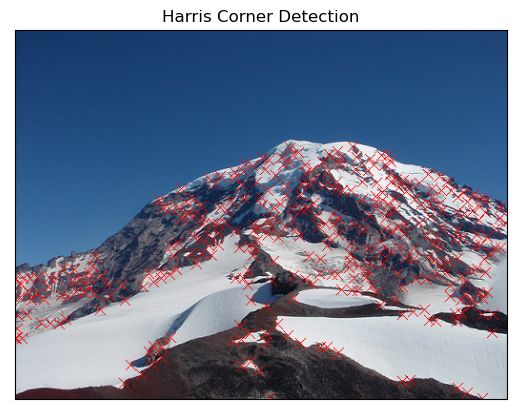

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = 'Mount1.png'
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

block_size = 2
ksize = 3
k = 0.04
cornerness = cv2.cornerHarris(gray_image, block_size, ksize, k)
threshold = 0.01 * cornerness.max()

# Non-max suppression with Chebyshev distance 
# (For every pixel in the image, check every neighbor within w pixels (Chebyshev distance). 
# Equivalently, check the 2w+1 window centered at each pixel.)
w = 5
h, w_img = cornerness.shape
suppressed = cornerness.copy()
for y in range(h):
    for x in range(w_img):
        window = cornerness[max(0, y - w):min(h, y + w + 1), max(0, x - w):min(w_img, x + w + 1)]
        if cornerness[y, x] != np.max(window):
            suppressed[y, x] = -np.inf

final_corners = np.where(suppressed > threshold)

cross_size = 5
line_thickness = 1
line_color = (0, 0, 255)

for y, x in zip(final_corners[0], final_corners[1]):
    cv2.line(image, (x - cross_size, y - cross_size), (x + cross_size, y + cross_size), line_color, line_thickness)
    cv2.line(image, (x - cross_size, y + cross_size), (x + cross_size, y - cross_size), line_color, line_thickness)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title('Harris Corner Detection')
plt.xticks([]), plt.yticks([]) 
plt.show()


# 2. 

In [19]:
def detect_harris_corners(gray_image, block_size=2, ksize=3, k=0.04, threshold_ratio=0.01, non_max_suppression_window=5):
    cornerness = cv2.cornerHarris(gray_image, block_size, ksize, k)

    # Set a cornerness threshold
    threshold = threshold_ratio * cornerness.max()

    # Non-max suppression with Chebyshev distance
    h, w_img = cornerness.shape
    suppressed = cornerness.copy()
    for y in range(h):
        for x in range(w_img):
            window = cornerness[max(0, y - non_max_suppression_window):min(h, y + non_max_suppression_window + 1),
                      max(0, x - non_max_suppression_window):min(w_img, x + non_max_suppression_window + 1)]
            if cornerness[y, x] != np.max(window):
                suppressed[y, x] = -np.inf

    # Get the final corner points
    final_corners = np.where(suppressed > threshold)

    return final_corners


In [20]:
# import cv2
# import numpy as np

# def match_corners(corners1, corners2, image1, image2, patch_size=5, distance_threshold=0.8):
#     matched_pairs = []
    
#     for y1, x1 in zip(corners1[0], corners1[1]):
#         best_distance = float('inf')
#         best_match = None
        
#         patch1 = image1[y1 - patch_size:y1 + patch_size + 1, x1 - patch_size:x1 + patch_size + 1]
        
#         for y2, x2 in zip(corners2[0], corners2[1]):
#             patch2 = image2[y2 - patch_size:y2 + patch_size + 1, x2 - patch_size:x2 + patch_size + 1]
            
#             if patch1.shape != patch2.shape:
#                 continue
                
#             distance = np.sum((patch1 - patch2) ** 2)
            
#             if distance < best_distance:
#                 best_distance = distance
#                 best_match = (y2, x2)
                
#         if best_match is not None:
#             matched_pairs.append((y1, x1, best_match[0], best_match[1], best_distance))
    
#     # Sort matched pairs by distance
#     matched_pairs.sort(key=lambda x: x[4])
    
#     # Perform reciprocal matching
#     reciprocal_matches = []
#     for i, (y1, x1, y2, x2, _) in enumerate(matched_pairs):
#         best_match = matched_pairs[np.argmin([mp[4] for mp in matched_pairs if mp[2] == y2 and mp[3] == x2])]
        
#         if best_match[2] == y1 and best_match[3] == x1:
#             reciprocal_matches.append((y1, x1, y2, x2))
    
#     return reciprocal_matches

# # Load images and convert them to grayscale
# image_path1 = 'Mount1.png'
# image_path2 = 'Mount2.png'
# image1 = cv2.imread(image_path1)
# image2 = cv2.imread(image_path2)
# gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
# gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# # Detect corners using the Harris corner detector
# corners1 = detect_harris_corners(gray_image1)
# corners2 = detect_harris_corners(gray_image2)

# # Match corners
# matched_corners = match_corners(corners1, corners2, gray_image1, gray_image2)

# # Print matched corner pairs
# print(matched_corners)


In [ ]:
def match_corners(corners1, corners2, image1, image2, patch_size=5, distance_threshold_ratio=0.6):
    matched_pairs = []
    
    for y1, x1 in zip(corners1[0], corners1[1]):
        best_distance = float('inf')
        best_match = None
        
        patch1 = image1[y1 - patch_size:y1 + patch_size + 1, x1 - patch_size:x1 + patch_size + 1]
        
        for y2, x2 in zip(corners2[0], corners2[1]):
            patch2 = image2[y2 - patch_size:y2 + patch_size + 1, x2 - patch_size:x2 + patch_size + 1]
            
            if patch1.shape != patch2.shape:
                continue
                
            distance = np.sum((patch1 - patch2) ** 2)
            
            if distance < best_distance:
                best_distance = distance
                best_match = (y2, x2)
                
        if best_match is not None:
            matched_pairs.append((y1, x1, best_match[0], best_match[1], best_distance))
    
    # Sort matched pairs by distance
    matched_pairs.sort(key=lambda x: x[4])
    max_distance = matched_pairs[-1][4]
    distance_threshold = distance_threshold_ratio * max_distance
    
    # Apply distance threshold
    filtered_pairs = [pair for pair in matched_pairs if pair[4] < distance_threshold]
    
    # Perform reciprocal matching
    reciprocal_matches = []
    for i, (y1, x1, y2, x2, _) in enumerate(filtered_pairs):
        best_match = filtered_pairs[np.argmin([mp[4] for mp in filtered_pairs if mp[2] == y2 and mp[3] == x2])]
        
        if best_match[2] == y1 and best_match[3] == x1:
            reciprocal_matches.append((y1, x1, y2, x2))
    
    return reciprocal_matches


In [ ]:
# Load images and convert them to grayscale
image_path1 = 'Mount1.png'
image_path2 = 'Mount2.png'
image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Detect corners using the Harris corner detector
corners1 = detect_harris_corners(gray_image1)
corners2 = detect_harris_corners(gray_image2)

# Match corners
matched_corners = match_corners(corners1, corners2, gray_image1, gray_image2)

# Draw matched corners on images
for y1, x1, y2, x2 in matched_corners:
    cv2.circle(image1, (x1, y1), 3, (0, 255, 0), 1)
    cv2.circle(image2, (x2, y2), 3, (0, 255, 0), 1)

# Display images with matched corners
cv2.imshow("Image 1", image1)
cv2.imshow("Image 2", image2)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [21]:
def match_corners(corners1, corners2, image1, image2, patch_size=5, distance_threshold_ratio=0.6):
    matched_pairs = []
    
    for y1, x1 in zip(corners1[0], corners1[1]):
        best_distance = float('inf')
        best_match = None
        
        patch1 = image1[y1 - patch_size:y1 + patch_size + 1, x1 - patch_size:x1 + patch_size + 1]
        
        for y2, x2 in zip(corners2[0], corners2[1]):
            patch2 = image2[y2 - patch_size:y2 + patch_size + 1, x2 - patch_size:x2 + patch_size + 1]
            
            if patch1.shape != patch2.shape:
                continue
                
            distance = np.sum((patch1 - patch2) ** 2)
            
            if distance < best_distance:
                best_distance = distance
                best_match = (y2, x2)
                
        if best_match is not None:
            matched_pairs.append((y1, x1, best_match[0], best_match[1], best_distance))
    
    # Sort matched pairs by distance
    matched_pairs.sort(key=lambda x: x[4])
    max_distance = matched_pairs[-1][4]
    distance_threshold = distance_threshold_ratio * max_distance
    
    # Apply distance threshold
    filtered_pairs = [pair for pair in matched_pairs if pair[4] < distance_threshold]
    
    # Perform reciprocal matching
    reciprocal_matches = []
    for i, (y1, x1, y2, x2, _) in enumerate(filtered_pairs):
        best_match = filtered_pairs[np.argmin([mp[4] for mp in filtered_pairs if mp[2] == y2 and mp[3] == x2])]
        
        if best_match[2] == y1 and best_match[3] == x1:
            reciprocal_matches.append((y1, x1, y2, x2))
    
    return reciprocal_matches


In [22]:
image_path1 = 'Mount1.png'
image_path2 = 'Mount2.png'
image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Detect corners using the Harris corner detector
corners1 = detect_harris_corners(gray_image1)
corners2 = detect_harris_corners(gray_image2)

# Match corners
matched_corners = match_corners(corners1, corners2, gray_image1, gray_image2)

# Print matched corner pairs
print(matched_corners)

[]


In [23]:
# import cv2
# import numpy as np

# # Load images and convert them to grayscale
# image_path1 = 'Mount1.png'
# image_path2 = 'Mount2.png'
# image1 = cv2.imread(image_path1)
# image2 = cv2.imread(image_path2)
# gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
# gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# # Detect corners using the Harris corner detector
# corners1 = detect_harris_corners(gray_image1)
# corners2 = detect_harris_corners(gray_image2)

# # Create ORB extractor
# orb = cv2.ORB_create()

# def extract_keypoints(corners, gray_image):
#     keypoints = [cv2.KeyPoint(x, y, 1) for y, x in zip(corners[0], corners[1])]
#     keypoints, descriptors = orb.compute(gray_image, keypoints)
#     return keypoints, descriptors

# keypoints1, descriptors1 = extract_keypoints(corners1, gray_image1)
# keypoints2, descriptors2 = extract_keypoints(corners2, gray_image2)

# # Create BFMatcher object
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# # Match descriptors
# matches = bf.match(descriptors1, descriptors2)

# # Sort matches by distance
# matches = sorted(matches, key=lambda x: x.distance)

# # Draw the matches
# result = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# # Show the result
# cv2.imshow("Matches", result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'KeyPoint'
> Overload resolution failed:
>  - Argument 'x' can not be safely parsed to 'float'
